# Leveling The Playing Field

## Overview
We all know that student performances differ every year, but by how much? We explore student performance trends from each year. We discuss findings and make recommendations based on them.

## The Dataset
The dataset consists of student grades broken down by assignments, quizzes, and exams from years 2014 to 2017. It comes with the following tables:
* students
* assignments
* quizzes
* exams
* weights

We begin by reading in our raw data

In [1]:
# Import library(ies)
import pandas as pd

# Read raw data
readData = lambda src: pd.read_csv("student-data-generator/data/" + src + ".csv")
assignmentData = readData("assignments")
examData = readData("exams")
quizData = readData("quizzes")
studentData = readData("students")
weightData = readData("weights")

## Initial Processing
Unfortunately, not all assignments, quizzes, and scores have scores. We forgive unavailable data by calculating averages based on the ones that do have scores. Unavailable scores are assigned a value of `-1`, and the rest are ranged from `0` to `100`. We calculate the average for each student and place them on a new column.

In [2]:
# Append column with student averages,
# counting available scores

# Utility function for calculate average
def calcAvg(scores):
    n = 0
    tot = 0
    for score in scores:
        # Make sure that score is valid
        if isinstance(score, (float, int)) and score >= 0 and score <= 100:
            n += 1
            tot += score
    
    # If no assignment got turned in, return -1
    return tot / n if n else -1

assignmentData["Assignment Avg"] = assignmentData.apply(calcAvg, axis=1)
examData["Exam Avg"] = examData.apply(calcAvg, axis=1)
quizData["Quiz Avg"] = quizData.apply(calcAvg, axis=1)

Now, we can find the percentages for each student.

In [3]:
# Extract averages
assignmentAverages = assignmentData[["Student ID", "Assignment Avg"]]
examAverages = examData[["Student ID", "Exam Avg"]]
quizAverages = quizData[["Student ID", "Quiz Avg"]]

# Merge averages with student data
merge = lambda studentTable, otherTable: pd.merge(studentTable, otherTable, on="Student ID")
studentAverages = merge(studentData, assignmentAverages)
studentAverages = merge(studentAverages, quizAverages)
studentAverages = merge(studentAverages, examAverages)

# Calculate grade percentage for each student
weightMap = {}
for _, row in weightData.iterrows():
    weightMap[row["Category"]] = row["Weight"]

def calcPercentage(row):
    assignmentWeight = weightMap["Assignments"] * row["Assignment Avg"] / 100
    examWeight = weightMap["Exams"] * row["Exam Avg"] / 100
    quizWeight = weightMap["Quizzes"] * row["Quiz Avg"] / 100
    return assignmentWeight + examWeight + quizWeight

studentAverages["Percentage"] = studentAverages.apply(calcPercentage, axis=1)

studentAverages.head()

,Student ID,Name,Year,Assignment Avg,Quiz Avg,Exam Avg,Percentage
0,101374,Apple Almond,2016,78.400000,26.8,84.75,75.422500
1,101473,Apple Cashew,2016,93.888889,93.6,79.75,83.241389
2,102794,Apple Peanut,2017,37.200000,76.2,26.25,34.837500
3,103387,Apple Hazelnut,2016,78.777778,76.0,85.75,83.590278


## Trending Average

After getting percentages for each student, we collect the average from each year and plot them.

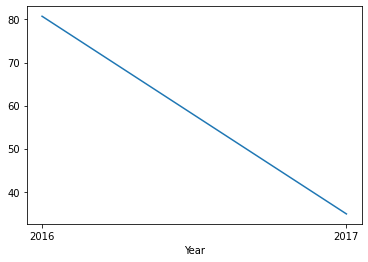

In [10]:
# Group by Year and then average the averages
yearlyAvg = studentAverages.groupby("Year")["Percentage"].mean()
yearlyPlot = yearlyAvg.plot.line()
yearlyPlot.locator_params(integer=True)